# Simple sorter on generated dataset

Here we will simulate 5min of a very simple dataset one tetrode with 5 units.

We will run a very simple sorter on it which is the very lagacy way on doing spike sorting:
  1. preprocess signal
  2. detect peaks with a treshold
  3. extract waveforms snipets
  4. project using SVD (aka PCA)
  5. run and try some clustering algos on it : HDBSCAN or KMeans or MeanShift or ...


This will shoudl demonstrate how easy to do legacy spike sorting and also the drawback and limit of this 
apprach without template matching.


In [1]:
# this is for debuging
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# some imports
from pathlib import Path
import shutil

import numpy as np

import matplotlib.pyplot as plt

import spikeinterface.full as si

In [3]:
# the path where we want to run the spike sorting
base_folder = Path("/home/samuel/DataSpikeSorting")


In [4]:
job_kwargs = dict(n_jobs=-1, progress_bar=True, chunk_duration="1s")

## Generate data

spikeinterface have a from simple to sophisticated way of generating fake dataset with the grountruth

Here we simulated a simple recording of 5 min with 5 units on a tetrode.

In [5]:
recording, gt_sorting = si.generate_ground_truth_recording(
    durations=[300.0, ],
    sampling_frequency=30000.0,
    num_channels=4,
    num_units=5,
    generate_sorting_kwargs=dict(firing_rates=3.0, refractory_period_ms=4.0),
    noise_kwargs=dict(noise_level=5.0, strategy="on_the_fly"),
    seed=2205,
)
recording

InjectTemplatesRecording: 4 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 137.33 MiB

### Run a sorter

In [6]:
sorter_folder = base_folder / "dev_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=8000.0),
    detection=dict(peak_sign="neg", detect_threshold=5., exclude_sweep_ms=0.4, radius_um=100),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting = si.run_sorter("simple", recording, output_folder=sorter_folder, verbose=True, **sorter_params)
print(sorting)


detect peaks using locally_exclusive with n_jobs = 12 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 2014 peaks in total
extract waveforms shared_memory mono buffer with n_jobs = 12 and chunk_size = 30000


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extracting features with n_jobs = 12 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

simple run time 5.95s
NumpyFolderSorting: 6 units - 1 segments - 30.0kHz


### lets explore features

Our "simple_sorter" leave some files we can explore after the `run_sorter(...)`


The file `features_tsvd.npy` contains the features computed by our sorter.

The file `peak_labels.npy` contains the labels set by our sorter.


The shape is `(num_spikes, num_components, num_channels)`.

This can be flatten and then analyzed with umap for a simple display.

We can see that algoythm HDBSCAN we choose agree with UMAP dimension reduction.

In [7]:
features = np.load(sorter_folder / "sorter_output/features/features_tsvd.npy")

features_flat = features.reshape(features.shape[0], -1)

peak_labels = np.load(sorter_folder / "sorter_output/features/peak_labels.npy")

print(features_flat.shape, features.shape, peak_labels.shape,features.dtype)


(2014, 12) (2014, 3, 4) (2014,) float32


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


<Axes: >

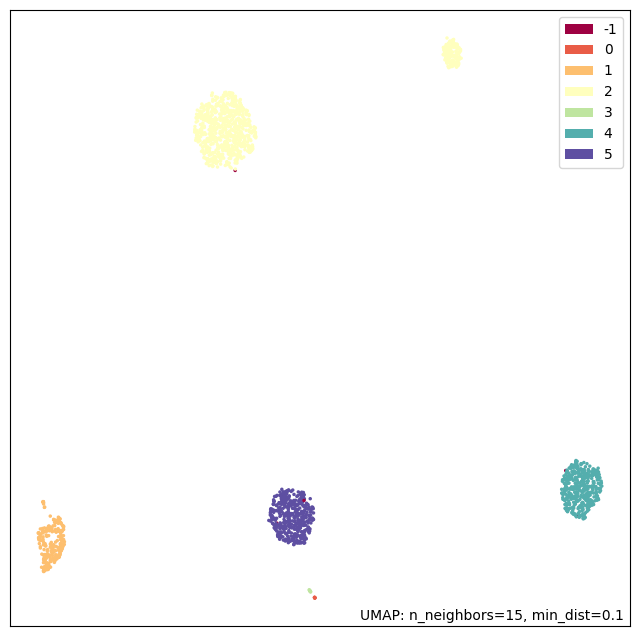

In [8]:
import umap
import umap.plot

mapper = umap.UMAP().fit(features_flat)
print(mapper)
umap.plot.points(mapper, labels=peak_labels)



## SortingAnalyzer

We run a SortingAnalyzer on this so we use the spikeinterface-gui to explore the result.

We can observe that 2 units should be merged.


In [13]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=False)
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/6 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/6 [00:00<?, ?it/s]

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:846: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


SortingAnalyzer: 4 channels - 6 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [ ]:
si.plot_sorting_summary(analyzer, backend="sortingview")


In [16]:
%gui qt
si.plot_sorting_summary(analyzer, backend="spikeinterface_gui")


## SortingAnalyzer on the groundtruth

In [17]:
gt_analyzer = si.create_sorting_analyzer(gt_sorting, recording, sparse=False)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
gt_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
gt_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
gt_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/5 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/5 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 5 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [ ]:
si.plot_sorting_summary(analyzer, backend="sortingview")


In [18]:
si.plot_sorting_summary(gt_analyzer, backend="spikeinterface_gui")

## Compare result to groundtruth

spikeinterface have a simple way check the result of a sorter and benchmark it to groundtruth sorting.

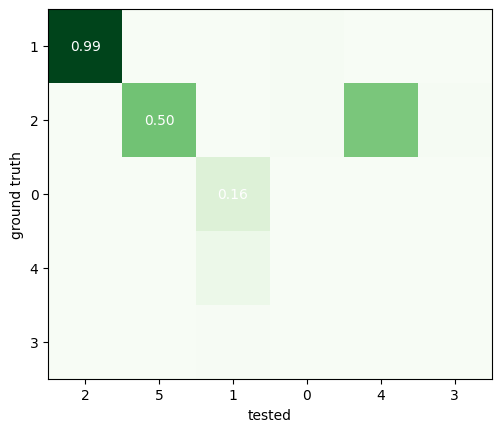

In [19]:
comp = si.compare_sorter_to_ground_truth(gt_sorting, sorting)
si.plot_agreement_matrix(comp)

## lets run another sorter

In [20]:
sorter_name = "tridesclous2"

sorter_folder = base_folder / f"dev_{sorter_name}"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)


sorting2 = si.run_sorter(sorter_name, recording, output_folder=sorter_folder, verbose=True)


write_memory_recording:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 11733 peaks in total
We kept 11733 peaks for clustering


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

pipeline:   0%|          | 0/300 [00:00<?, ?it/s]

split_clusters with local_feature_clustering:   0%|          | 0/4 [00:00<?, ?it/s]

find_merge_pairs with normalized_template_diff:   0%|          | 0/15 [00:00<?, ?it/s]

estimate_templates_average:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

tridesclous2 run time 58.88s


In [28]:
analyzer2 = si.create_sorting_analyzer(sorting2, recording, sparse=False)
analyzer2.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
analyzer2.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
analyzer2.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
analyzer2

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/6 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/6 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 6 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [24]:
%gui qt
si.plot_sorting_summary(analyzer2, backend="spikeinterface_gui")

## curation with quality metrics

In [36]:
metrics = analyzer2.get_extension("quality_metrics").get_data()
metrics

,amplitude_cutoff,rp_contamination,rp_violations,snr
0,0.000007,1.000000,24782.0,2.024653
2,0.000044,1.000000,24896.0,1.957789
4,0.000037,1.000000,24086.0,2.014688
5,0.002336,0.000000,0.0,12.035401
6,0.000025,1.000000,23612.0,1.983198
7,0.003536,0.205475,1.0,16.814564


In [39]:
keep = metrics.query("rp_contamination < 0.25 & snr > 7")
display(keep)

keep_unit_ids = keep.index.values
print(keep_unit_ids)


,amplitude_cutoff,rp_contamination,rp_violations,snr
5,0.002336,0.000000,0.0,12.035401
7,0.003536,0.205475,1.0,16.814564


[5 7]


In [40]:
analyzer3 = analyzer2.select_units(unit_ids=keep_unit_ids)
analyzer3
                                  

SortingAnalyzer: 4 channels - 2 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [42]:
%gui qt
si.plot_sorting_summary(analyzer3, backend="spikeinterface_gui")

## check with the ground truth

Here we compare the cleaned unit list from tridesclous2

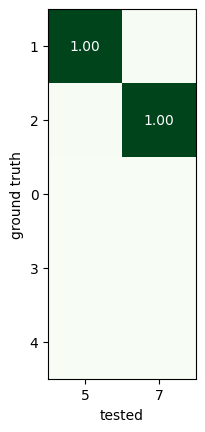

In [41]:
comp2 = si.compare_sorter_to_ground_truth(gt_sorting, analyzer3.sorting)
si.plot_agreement_matrix(comp2)